In [133]:
import os
import cv2
import time
import imutils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm#_notebook as tqdm


In [134]:
folderGlob = '/home/rob/HWR/datasets/zooniverse/**/Cropped00[2,4].jpg'
fps = glob(folderGlob)

In [135]:
def rotate_bound(image, angle, borderValue):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w / 2, h / 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH), borderValue=(borderValue,borderValue,borderValue))

In [136]:
def sobel(img, dx, dy, ksize):
    sobelx64f = cv2.Sobel(img,cv2.CV_64F,dx,dy,ksize=ksize)
    abs_sobel64f = np.absolute(sobelx64f)
    return np.uint8(abs_sobel64f)

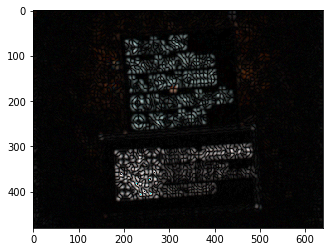

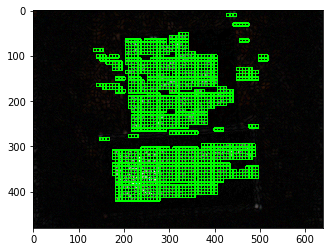

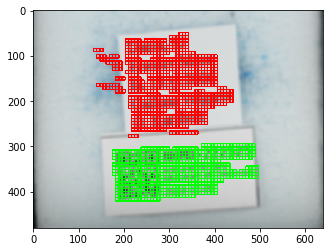

In [132]:
new_img_size = (480, 640)
squ_size = 7
assert squ_size%2 == 1
max_dist_btw = squ_size*2.5
min_consecutive = 3
min_squ_per_label = 40
threshold = 9
height, width = new_img_size

num = np.random.randint(3800)
orig = cv2.imread(fps[num])
orig_size = orig.shape[:2]
scale = np.array(orig_size) / np.array(new_img_size)
img = cv2.resize(orig, (width, height))

img = cv2.GaussianBlur(img, (11,11), 3)
sobel_xy = sobel(img, 1, 1, 5)

plt.imshow(sobel_xy)


consecutive = 0 
consecutive_coords = []
text_coords = []
for j in range(height//squ_size):
    sy = j*squ_size
    ey = j*squ_size + squ_size
    for i in range(width//squ_size):
        sx = i*squ_size
        ex = i*squ_size + squ_size

        squ = sobel_xy[sy:ey,sx:ex,:]

        _mean = squ.mean()
        if _mean >= threshold:
            consecutive += 1
            consecutive_coords += [(sx,sy,ex,ey)]

        elif consecutive >= 0:
            if consecutive >= min_consecutive:
                consecutive = 0
                text_coords += consecutive_coords
            else:
                consecutive = 0
                consecutive_coords = []

    if consecutive >= min_consecutive:
        text_coords += consecutive_coords
    consecutive_coords = []
    consecutive = 0


messy = sobel_xy.copy()
for (startX, startY, endX, endY) in text_coords:
    cv2.rectangle(messy, (startX, startY), (endX, endY), (0, 255, 0), 2)

plt.figure()
plt.imshow(messy)

coords_stack = text_coords.copy()

labels = []
while len(coords_stack):
    squ1 = coords_stack[0]
    sx1, sy1, ex1, ey1 = squ1
    mx1 = (sx1+ex1)/2
    my1 = (sy1+ey1)/2

    new_label = []
    to_be_checked = [squ1]
    coords_stack.remove(squ1)

    while len(to_be_checked):
        squ1 = to_be_checked[0]
        sx1, sy1, ex1, ey1 = squ1
        mx1 = (sx1+ex1)/2
        my1 = (sy1+ey1)/2

        new_label += [squ1]
        to_be_checked.remove(squ1)

        coords_stack2 = coords_stack.copy()
        for i in range(len(coords_stack2)):
            squ2 = coords_stack2[i]
            sx2, sy2, ex2, ey2 = squ2
            mx2 = (sx2+ex2)/2
            my2 = (sy2+ey2)/2
            dist = np.sqrt((mx1-mx2)**2 + (my1-my2)**2)
            if dist <= max_dist_btw:
                to_be_checked += [squ2]
                coords_stack.remove(squ2)
    if len(new_label) >= min_squ_per_label:
        labels += [new_label]


colors = [(255,0,0),(0,255,0),(0,0,255),(255,255,0),(255,0,255),(0,255,255),(255,255,255),(100,100,100)]
messy = img.copy()
color = 0
for label in labels:
    for (startX, startY, endX, endY) in label:
        cv2.rectangle(messy, (startX, startY), (endX, endY), colors[color], 2)
    color += 1
    if color == len(colors):
        color = 0


plt.figure()
plt.imshow(messy)

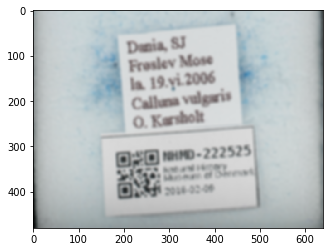

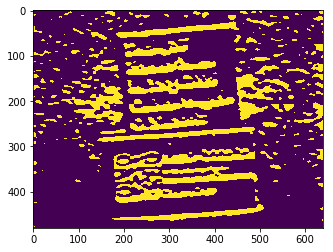

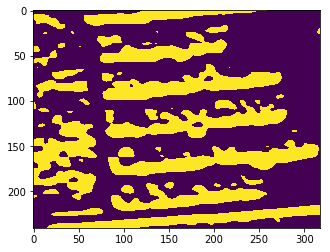

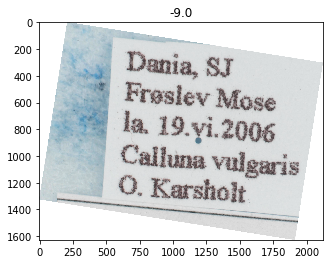

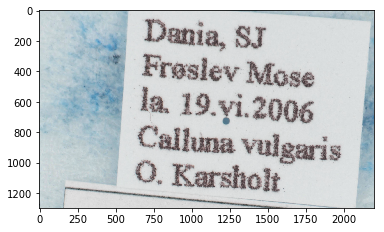

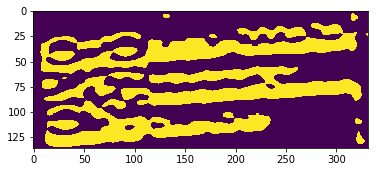

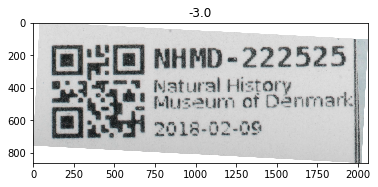

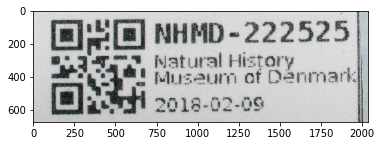

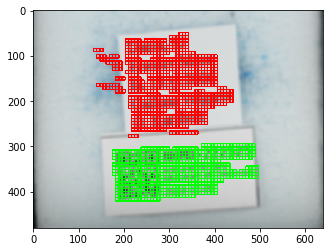

In [137]:
dy = cv2.filter2D(img, -1, y_filter)
dy = cv2.cvtColor(dy, cv2.COLOR_BGR2GRAY)
_,dy = cv2.threshold(dy,int(dy.mean()),255,cv2.THRESH_BINARY)
dy = dy / 255
max_angle = 10
n_angles = 21
pad = 5
plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(dy)
i = 0
for label in labels:
    label = np.array(label)
    sx = max(label.min(axis=0)[0]-pad,0)
    sy = max(label.min(axis=0)[1]-pad,0)
    ex = min(label.max(axis=0)[2]+pad,width)
    ey = min(label.max(axis=0)[3]+pad,height)

    center = ((ex+sx)//2,(ey+sy)//2)

    label_img = dy[sy:ey,sx:ex].copy()
    label_width, label_height = label_img.shape[:2]

    plt.figure()
    plt.imshow(label_img)
    #circle_center = (label_height//2, label_width//2)
    #circle_radius = int(np.sqrt((label_height//2)**2 + (label_width//2)**2))
    #circle_width = circle_radius - min(label_width, label_height)//2
    #cv2.circle(label_img, circle_center, circle_radius, (0,0,0), circle_width*2)
    best_sum = 0
    best_angle = np.nan
    for angle in np.linspace(-max_angle,max_angle,n_angles):
        dst = imutils.rotate(label_img, angle)
        hor_sum = dst.sum(axis=1)
        hist,bins = np.histogram(hor_sum, bins = 10, density=True)
        #plt.figure()
        #plt.imshow(dst)
        #plt.title(str(round(angle,2)) + ', ' + str(hist))
        
        if hist[0] > best_sum:#max(hor_sum) > best_sum:
            best_sum = hist[0]
            best_angle = angle
    
    

            
    #scale back to original image
    sx = int(scale[1]*(sx))
    sy = int(scale[0]*(sy))
    ex = int(scale[1]*(ex))
    ey = int(scale[0]*(ey))
    dst = rotate_bound(orig[sy:ey,sx:ex].copy(), best_angle, borderValue=255)
    
    plt.figure()
    plt.imshow(dst)
    plt.title(str(best_angle))
    
    
    M = cv2.getRotationMatrix2D((0, 0), best_angle, 1.0)
    rotated_squs = [np.append(a[:2],[1]) for a in label]
    rotated_squs += [np.append(a[2:],[1]) for a in label]
    rotated_squs = np.dot(rotated_squs, M.T)
    sx = rotated_squs.min(axis=0)[0]
    sy = rotated_squs.min(axis=0)[1]
    ex = rotated_squs.max(axis=0)[0]
    ey = rotated_squs.max(axis=0)[1]
    sx = int(scale[1]*(sx))
    sy = int(scale[0]*(sy))
    ex = int(scale[1]*(ex))
    ey = int(scale[0]*(ey))
    
    
    x_offset = 0
    y_offset = 0
    sx_offset = 0
    sy_offset = 0
    if best_angle < 0:
        x_offset = np.abs((orig.shape[0])*np.sin(best_angle*np.pi/180))
        sx_offset = np.abs((ey-sy)*np.sin(best_angle*np.pi/180))
    elif best_angle > 0: 
        y_offset = np.abs((orig.shape[1])*np.sin(best_angle*np.pi/180))
        sy_offset = np.abs((ex-sx)*np.sin(best_angle*np.pi/180))
    
    
    #start = np.array([sx,sy,1])
    #end = np.array([ex,ey,1])
    #nsx,nsy = np.dot(start, M.T)
    nsx = int(sx + x_offset - sx_offset)
    nsy = int(sy + y_offset - sy_offset)
    #nex,ney = np.dot(end, M.T)
    nex = int(ex + x_offset + sx_offset)
    ney = int(ey + y_offset + sy_offset)
    dst = rotate_bound(orig, best_angle, borderValue=255)
    plt.figure()
    plt.imshow(dst[nsy:ney,nsx:nex])
    #new_fp = fp.replace('Cropped','Label').replace('.jpg','%s.jpg'%i)
    #cv2.imwrite(new_fp, dst[nsy:ney,nsx:nex])

    i+=1


plt.figure()
plt.imshow(messy)

In [124]:
rotated_squs

array([[253.54286524, 404.91729462],
       [260.4906883 , 405.77038003],
       [267.43851136, 406.62346543],
       [252.68977984, 411.86511769],
       [259.6376029 , 412.71820309],
       [266.58542596, 413.57128849],
       [251.83669443, 418.81294075],
       [258.78451749, 419.66602615],
       [265.73234056, 420.51911155],
       [244.03578597, 424.9076784 ],
       [250.98360903, 425.76076381],
       [257.93143209, 426.61384921],
       [264.87925515, 427.46693462],
       [237.08796291, 424.054593  ],
       [243.18270056, 431.85550147],
       [250.13052363, 432.70858687],
       [257.07834669, 433.56167227],
       [264.02616975, 434.41475768],
       [229.28705444, 430.14933066],
       [236.2348775 , 431.00241606],
       [235.3817921 , 437.95023912],
       [242.32961516, 438.80332453],
       [249.27743822, 439.65640993],
       [256.22526128, 440.50949534],
       [263.17308434, 441.36258074],
       [270.12090741, 442.21566614],
       [222.33923138, 429.29624525],
 

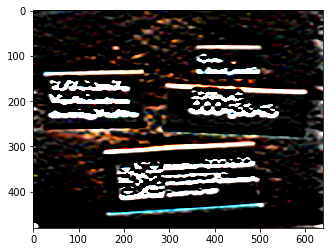

In [87]:
y_filter = np.ones((9,9))
y_filter[:4] = -1
y_filter[4] = 0
plt.imshow(cv2.filter2D(img, -1, y_filter))

In [97]:
sobel_y.shape

(480, 640, 3)

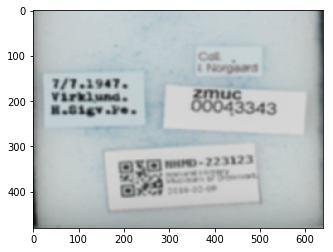

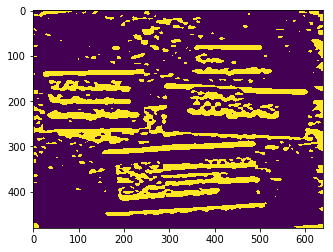

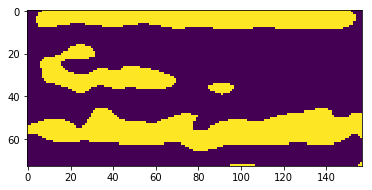

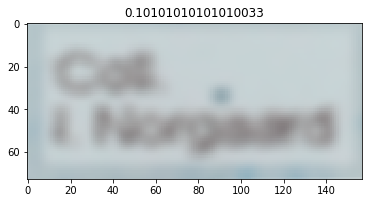

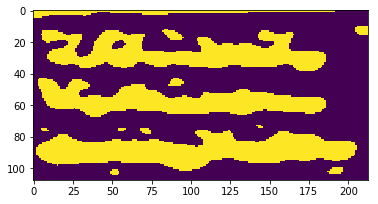

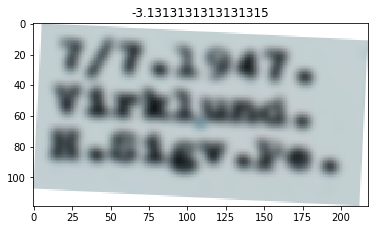

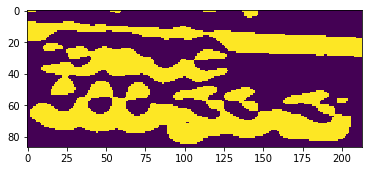

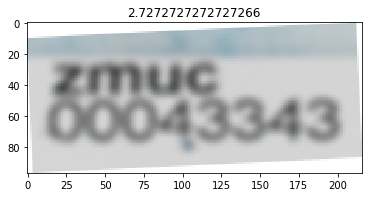

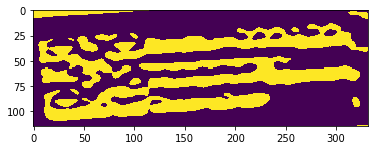

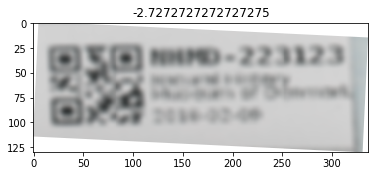

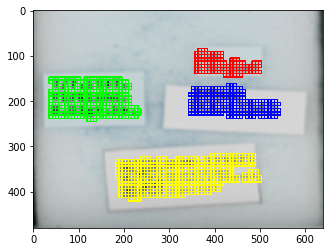

In [98]:
sobel_y = sobel(img, 0, 1, 3)
sobel_y = cv2.filter2D(img, -1, y_filter)
sobel_y = cv2.cvtColor(sobel_y, cv2.COLOR_BGR2GRAY)
_,sobel_y = cv2.threshold(sobel_y,int(sobel_y.mean()),255,cv2.THRESH_BINARY)
max_angle = 10
n_angles = 100
pad = 5
plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(sobel_y)
for label in labels:
    label = np.array(label)
    sx,sy = label.min(axis=0)[:2] - pad
    ex,ey = label.max(axis=0)[2:] + pad
    
    center = ((ex+sx)//2,(ey+sy)//2)
    
    label_img = sobel_y[sy:ey,sx:ex].copy()
    #label_img = cv2.cvtColor(label_img, cv2.COLOR_BGR2GRAY)
    label_width, label_height = label_img.shape[:2]
    
    plt.figure()
    plt.imshow(label_img)
    circle_center = (label_height//2, label_width//2)
    circle_radius = int(np.sqrt((label_height//2)**2 + (label_width//2)**2))
    circle_width = circle_radius - min(label_width, label_height)//2
    cv2.circle(label_img, circle_center, circle_radius, (0,0,0), circle_width*2)
    best_sum = 0
    best_angle = np.nan
    for angle in np.linspace(-max_angle,max_angle,n_angles):
        dst = imutils.rotate(label_img, angle)
        hor_sum = dst.sum(axis=1)/dst.sum()
        hist,bins = np.histogram(hor_sum, density=True)
        #print(angle)
        #print(hist[:3].sum())
        #plt.figure()
        #plt.hist(hor_sum, normed=True)
        #plt.title(angle)
        #plt.figure()
        #plt.imshow(dst)
        
        if max(hor_sum) > best_sum:
            best_sum = max(hor_sum)
            best_angle = angle
    
    dst = rotate_bound(img[sy:ey,sx:ex].copy(), best_angle, borderValue=255)
    
    plt.figure()
    plt.imshow(dst)
    plt.title(str(best_angle))
plt.figure()
plt.imshow(messy)

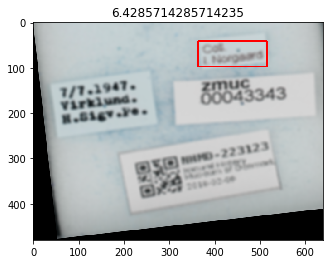

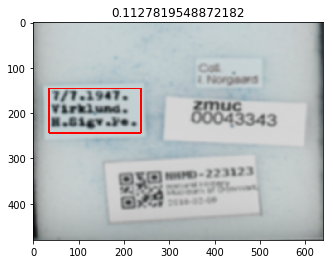

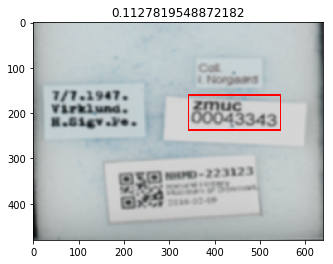

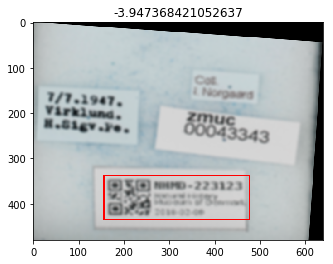

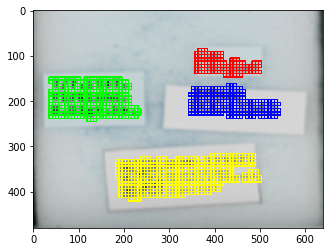

In [80]:
import imutils
max_angle = 45
n_angles = 400
for label in labels:
    #find centroid
    
    corners = [rect[:2] + (1,) for rect in label]
    corners += [rect[2:] + (1,) for rect in label]
    
    
    smallest_area = np.inf
    best_angle = np.nan
    for angle in np.linspace(-max_angle,max_angle,n_angles):
        M = cv2.getRotationMatrix2D((0,0),angle,1)
        rotated_corners = np.dot(corners, M.T)
        sx,sy = rotated_corners.min(axis=0)
        ex,ey = rotated_corners.max(axis=0)
        area = (ex-sx)*(ey-sy)
        if area < smallest_area:
            smallest_area = area
            best_angle = angle
            best_coords = (int(sx),int(sy),int(ex),int(ey))
    
    M = cv2.getRotationMatrix2D((0,0),best_angle,1)
    #dst = imutils.rotate_bound(img, best_angle)
    dst = cv2.warpAffine(img, M, (width, height))
    cv2.rectangle(dst,best_coords[:2],best_coords[2:],(255,0,0),2)
    
    
    plt.figure()
    plt.imshow(dst)
    plt.title(str(best_angle))
plt.figure()
plt.imshow(messy)

In [213]:
sy,ey,sx,ex

(-98.99494936611663, 45.9619407771256, 84.8528137423857, 236.8807716974934)

In [205]:
test = np.array([[0,0,1],[0,1,1],[1,0,1],[-1,1,1]])
test,np.dot(test,M.T)

(array([[ 0,  0,  1],
        [ 0,  1,  1],
        [ 1,  0,  1],
        [-1,  1,  1]]), array([[ 0.00000000e+00,  0.00000000e+00],
        [ 7.07106781e-01,  7.07106781e-01],
        [ 7.07106781e-01, -7.07106781e-01],
        [-1.11022302e-16,  1.41421356e+00]]))

[[ 0.70710678  0.70710678  0.        ]
 [-0.70710678  0.70710678  0.        ]]


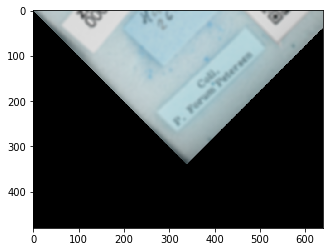

In [199]:
M = cv2.getRotationMatrix2D((0,0),45,1)
rot = cv2.warpAffine(img,M,(width, height))
print(M)
plt.imshow(rot)

In [103]:
img.shape,sobel_xy.shape

((480, 640, 3), (480, 640, 3))

100%|██████████| 96/96 [00:00<00:00, 447.77it/s]


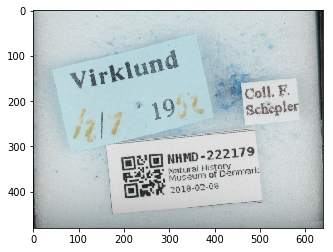

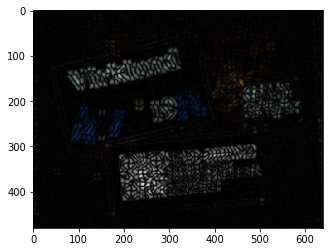

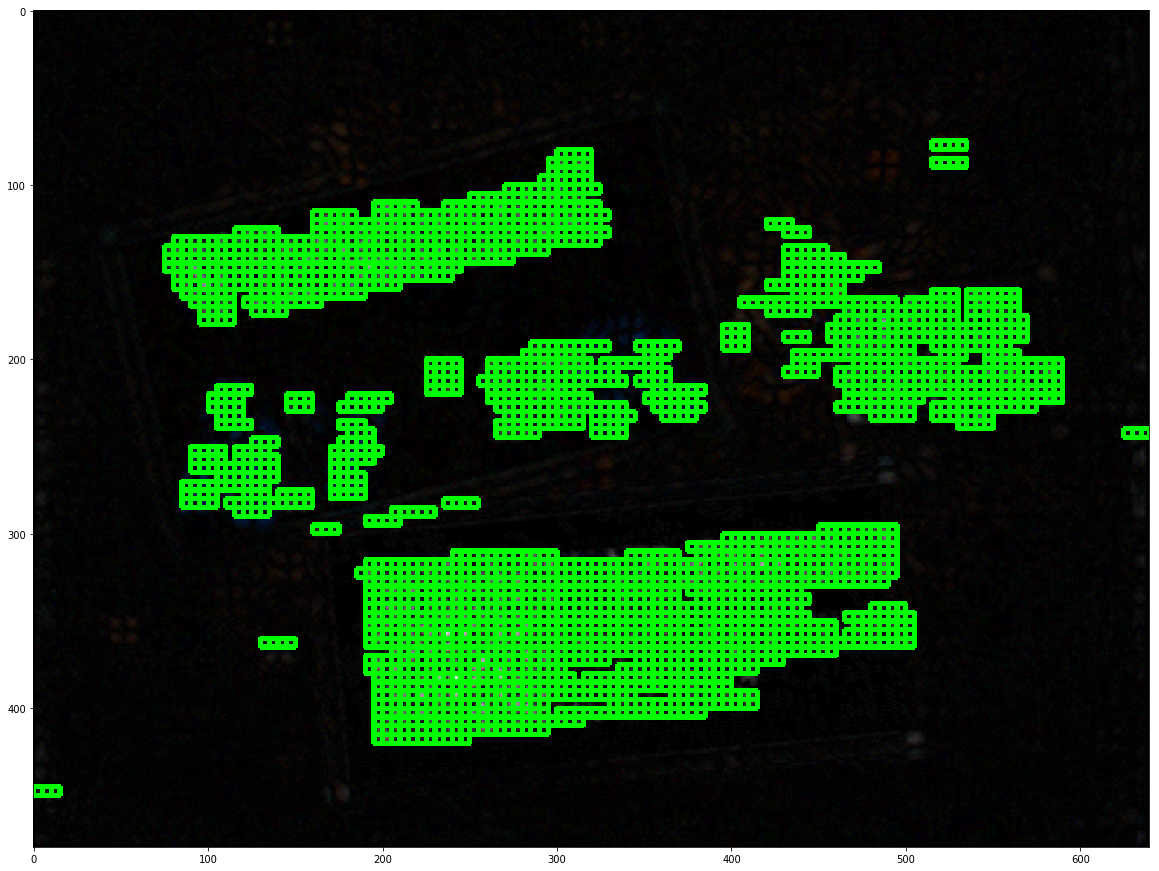

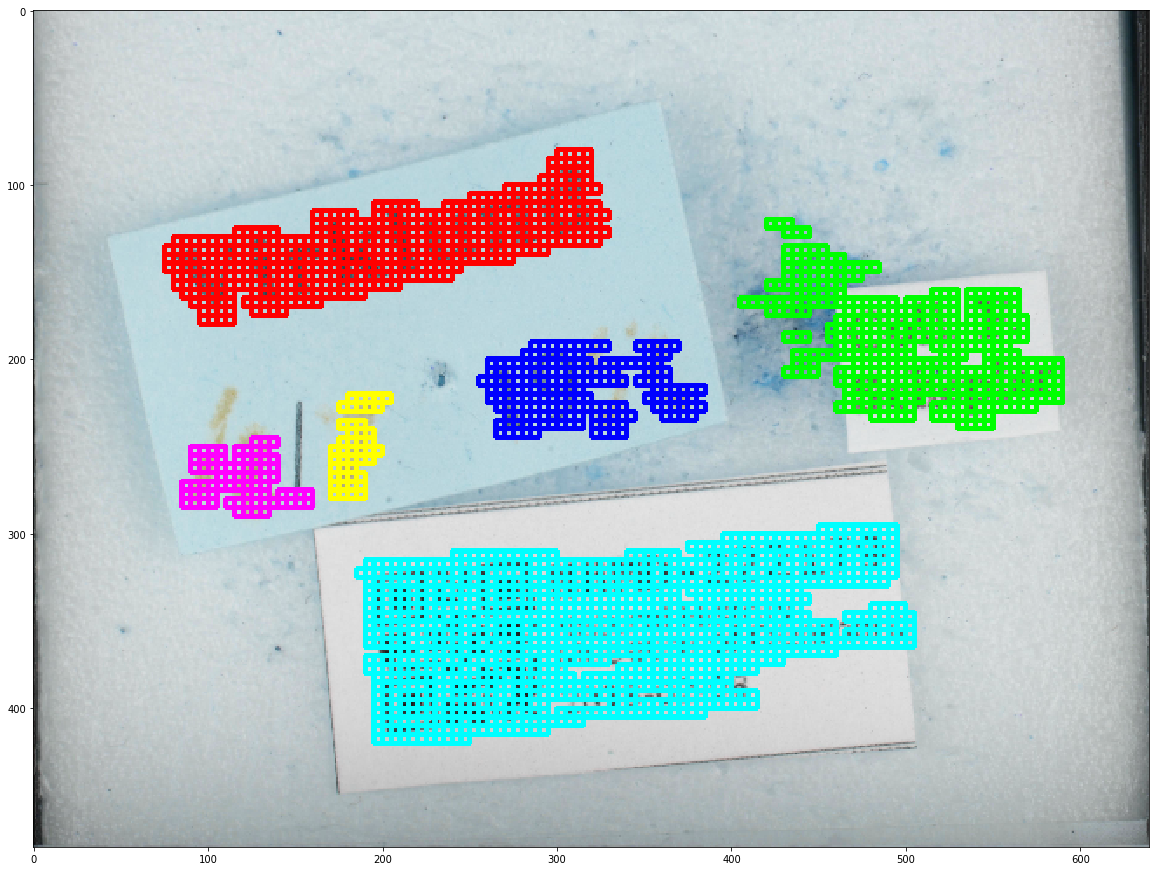

In [78]:
k = 1
consecutive = 0 
consecutive_coords = []
text_coords = []
threshold = 10
for j in tqdm(range(height//size)):
    sy = j*size
    ey = j*size + size
    for i in range(width//size):
        sx = i*size
        ex = i*size + size
        
        squ = img[sy:ey,sx:ex,:]
        
        _mean = squ.mean()
        if _mean >= threshold:
            consecutive += 1
            consecutive_coords += [(sx,sy,ex,ey)]
            squ.fill(255)
            squ = squ.astype('uint8')
            
        elif consecutive >= 0:
            if consecutive >= 3:
                consecutive = 0
                text_coords += consecutive_coords
            else:
                consecutive = 0
                consecutive_coords = []
    
    if consecutive >= 3:
        text_coords += consecutive_coords
    consecutive_coords = []
    consecutive = 0


#plt.show()

messy = sobel_8u.copy()
for (startX, startY, endX, endY) in text_coords:
    cv2.rectangle(messy, (startX, startY), (endX, endY), (0, 255, 0), 2)
    
#plt.figure(figsize=(20,20))
#plt.imshow(messy)

plt.figure(figsize=(20,20))
plt.imshow(messy)

#group into labels
coords_stack = text_coords.copy()
max_dist = size*2

labels = []
while len(coords_stack):
    squ1 = coords_stack[0]
    sx1, sy1, ex1, ey1 = squ1
    mx1 = (sx1+ex1)/2
    my1 = (sy1+ey1)/2
    
    new_label = []
    to_be_checked = [squ1]
    coords_stack.remove(squ1)
            
    while len(to_be_checked):
        squ1 = to_be_checked[0]
        sx1, sy1, ex1, ey1 = squ1
        mx1 = (sx1+ex1)/2
        my1 = (sy1+ey1)/2

        new_label += [squ1]
        to_be_checked.remove(squ1)
        
        coords_stack2 = coords_stack.copy()
        for i in range(len(coords_stack2)):
            squ2 = coords_stack2[i]
            sx2, sy2, ex2, ey2 = squ2
            mx2 = (sx2+ex2)/2
            my2 = (sy2+ey2)/2
            dist = np.sqrt((mx1-mx2)**2 + (my1-my2)**2)
            if dist <= max_dist:
                to_be_checked += [squ2]
                coords_stack.remove(squ2)
    labels += [new_label]

img = cv2.imread(fps[num])
img = cv2.resize(img, (160*4,120*4))

colors = [(255,0,0),(0,255,0),(0,0,255),(255,255,0),(255,0,255),(0,255,255),(255,255,255),(100,100,100)]
messy = img.copy()
color = 0
for label in labels:
    if len(label) > 40:
        for (startX, startY, endX, endY) in label:
            cv2.rectangle(messy, (startX, startY), (endX, endY), colors[color], 2)
        color += 1
        if color == len(colors):
            color = 0
            
    
plt.figure(figsize=(20,20))
plt.imshow(messy)